In [ ]:
pip install deepxde

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import deepxde as dde
from deepxde.backend import tf
from scipy.integrate import solve_ivp
sns.set_theme(style="darkgrid")

In [ ]:
s_0 = 0.8
i_0 = 0.2
r_0 = 0
y0 = [s_0, i_0, r_0]
beta = 0.8
gamma = 0.03
phi = 0.4
p = 0.3
parameters_real = {
    "beta": beta,
    "gamma": gamma,
    "phi": phi
}

In [ ]:
def generate_data(t_array,y0,):
  def func(t, y):
    s, i, r = y
    ds_dt = (1 - p) * phi - beta * s * i - phi * s
    di_dt = beta * s * i - gamma * i - phi * i
    dr_dt = p * phi + gamma * i - phi * r
    return np.array([ds_dt, di_dt, dr_dt])
  t_span = (t_array[0], t_array[-1])
  sol = solve_ivp(func, t_span, y0, t_eval=t_array)
  return sol.y.T

In [ ]:
n_days = 120
t_train = np.arange(0, n_days, 1)[:, np.newaxis]
y_train = generate_data(np.ravel(t_train), y0)
y_train.shape

(120, 3)

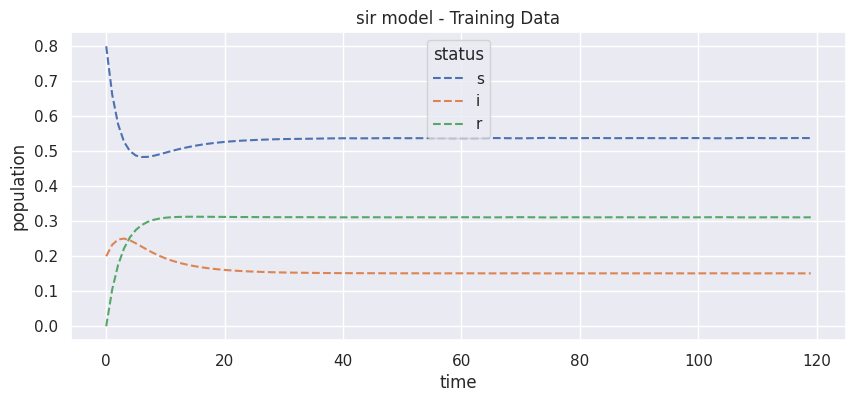

In [ ]:
model_name = "sir"
populations_names = list(model_name)
data_real = (pd.DataFrame(y_train, columns=populations_names).assign(time=t_train).melt(id_vars="time", var_name="status", value_name="population"))

fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(
data=data_real,
x="time",
y="population",
hue="status",
legend=True,
linestyle="dashed",
ax=ax
)

ax.set_title(f"{model_name} model - Training Data")
fig.show()

In [ ]:
_beta = dde.Variable(0.0)
_gamma = dde.Variable(0.0)
_phi = dde.Variable(0.0)

In [ ]:
def ode(t, y):
  s = y[:, 0:1]
  i = y[:, 1:2]
  r = y[:, 2:3]

  ds_dt = dde.grad.jacobian(y, t, i=0)
  di_dt = dde.grad.jacobian(y, t, i=1)
  dr_dt = dde.grad.jacobian(y, t, i=2)
  return [
  ds_dt - ((1 - p) * _phi - _beta * s * i - _phi * s),
  di_dt - (_beta * s * i - _gamma * i - _phi * i),
  dr_dt - (p * _phi + _gamma * i - _phi * r),
  ]

In [ ]:
# Geometry
geom = dde.geometry.TimeDomain(t_train[0, 0], t_train[-1, 0])
# Boundaries
def boundary(_, on_initial):
  return on_initial
# Initial conditions
s_0, i_0, r_0 = y_train[0, :]
ic_s = dde.icbc.IC(geom, lambda x: s_0, boundary, component=0)
ic_i = dde.icbc.IC(geom, lambda x: i_0, boundary, component=1)
ic_r = dde.icbc.IC(geom, lambda x: r_0, boundary, component=2)

In [ ]:
observed_s = dde.icbc.PointSetBC(t_train, y_train[:, 0:1], component=0)
observed_i = dde.icbc.PointSetBC(t_train, y_train[:, 1:2], component=1)
observed_r = dde.icbc.PointSetBC(t_train, y_train[:, 2:3], component=2)

In [ ]:
data = dde.data.PDE(
geom,
ode,
  [
  ic_s,
  ic_i,
  ic_r,
  observed_s,
  observed_i,
  observed_r,
  ],
num_domain=256,
num_boundary=2,
anchors=t_train,
)

In [ ]:
neurons = 70
layers = 3

In [ ]:
activation = "relu"
net = dde.nn.FNN([1] + [neurons] * layers + [3], activation, "Glorot uniform"
)

In [ ]:
variable_filename = "sir_variables.dat"
variable = dde.callbacks.VariableValue(
[_beta, _gamma, _phi],
period=100,
filename=variable_filename
)

Compiling model...
Building feed-forward neural network...
'build' took 0.048387 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.936720 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [8.17e-03, 3.63e-03, 1.05e-02, 6.40e-01, 4.00e-02, 0.00e+00, 4.50e+01, 1.62e+01, 5.41e+01]    [8.17e-03, 3.63e-03, 1.05e-02, 6.40e-01, 4.00e-02, 0.00e+00, 4.50e+01, 1.62e+01, 5.41e+01]    []  
5000      [1.71e-04, 1.29e-05, 1.10e-04, 1.07e-06, 8.58e-08, 6.60e-07, 5.15e-05, 3.56e-06, 2.86e-05]    [1.71e-04, 1.29e-05, 1.10e-04, 1.07e-06, 8.58e-08, 6.60e-07, 5.15e-05, 3.56e-06, 2.86e-05]    []  
10000     [2.85e-04, 1.50e-05, 7.95e-05, 2.16e-06, 2.94e-07, 1.84e-06, 2.48e-03, 2.47e-05, 1.56e-03]    [2.85e-04, 1.50e-05, 7.95e-05, 2.16e-06, 2.94e-07, 1.84e-06, 2.48e-03, 2.47e-05, 1.56e-03]    []  
15000     [1.40e-05, 1.95e-06, 8.16e-06, 4.79e-08, 1.30e-07, 4.77e-08, 7.09e-06, 1.15e-05, 6.83e-06]    [1.40e-05, 1.95e-06, 8.16e-06, 

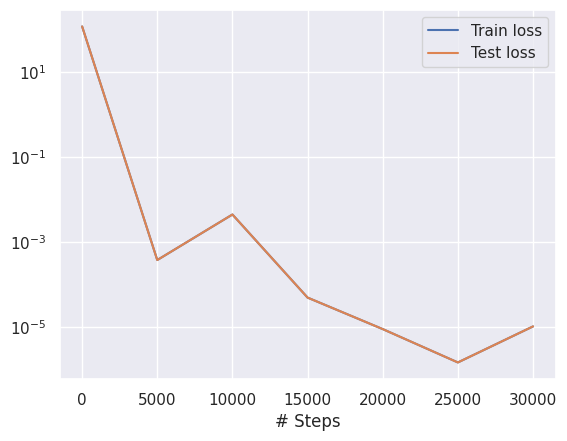

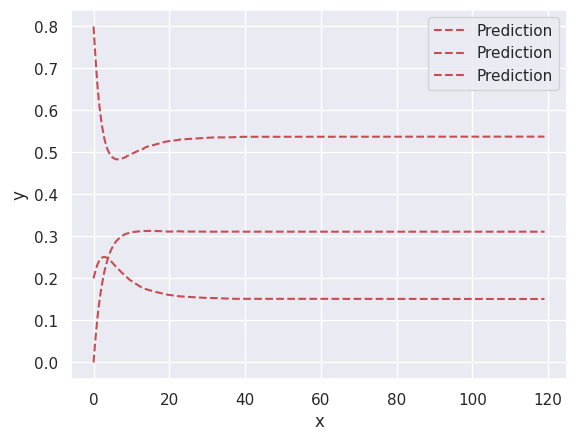

In [ ]:
model = dde.Model(data, net)
model.compile(
 "adam",
 lr=1e-3,
 external_trainable_variables=[_beta, _gamma, _phi]
 )
losshistory, train_state = model.train(
 iterations=30000,
 display_every=5000,
 callbacks=[variable]
 )
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

In [ ]:
t_pred = np.arange(0, n_days, 1)[:, np.newaxis]
y_pred = model.predict(t_pred)
data_pred = (
pd.DataFrame(y_pred, columns=populations_names, index=t_pred.ravel())
.rename_axis("time")
.reset_index()
.melt(id_vars="time", var_name="status", value_name="population")
)

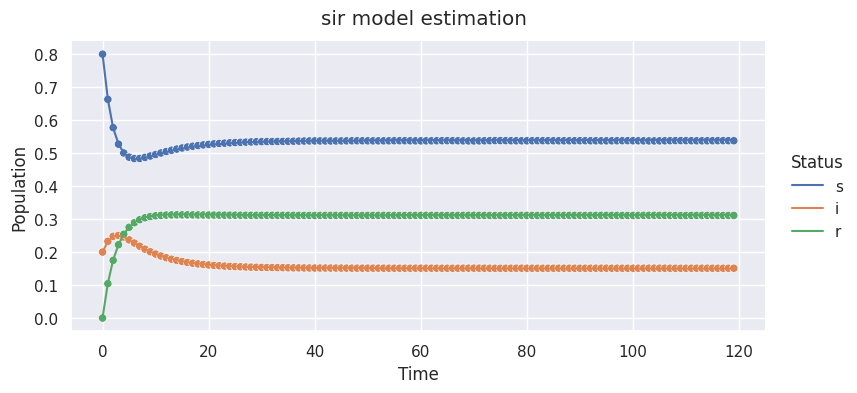

In [ ]:
g = sns.relplot(
data=data_pred,
x="time",
y="population",
hue="status",
kind="line",
aspect=2,
height=4
)
sns.scatterplot(
data=data_real,
x="time",
y="population",
hue="status",
ax=g.ax,
legend=False
)
(
g.set_axis_labels("Time", "Population")
.tight_layout(w_pad=1)
)
g._legend.set_title("Status")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle(f"sir model estimation")
plt.savefig("sir_prediction.png", dpi=300)
plt.show()

<ipython-input-56-f4ed6985a647>:26: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


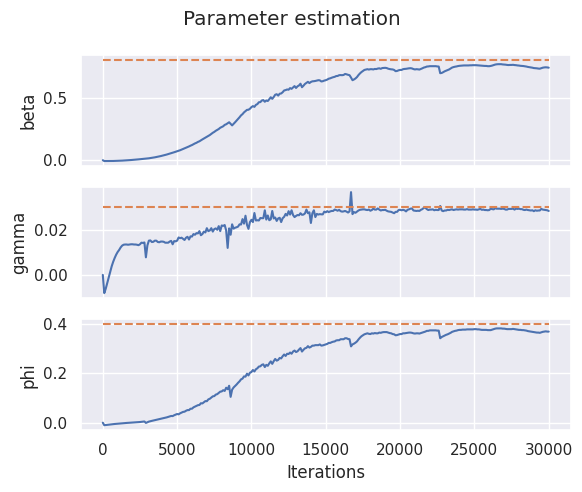

In [ ]:
lines = open(variable_filename, "r").readlines()
raw_parameters_pred_history = np.array(
[
 np.fromstring(
 min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line),
 key=len),
 sep=",",
 )
 for line in lines
 ]
 )
iterations = [int(re.findall("^[0-9]+", line)[0]) for line in lines]
parameters_pred_history = {
name: raw_parameters_pred_history[:, i]
for i, (name, nominal) in enumerate(parameters_real.items())
}
n_callbacis, n_variables = raw_parameters_pred_history.shape
fig, axes = plt.subplots(nrows=n_variables, sharex=True, figsize=(6, 5),
layout="constrained")
for ax, (parameter, parameter_value) in zip(axes, parameters_real.items()):
  ax.plot(iterations, parameters_pred_history[parameter] , "-")
  ax.plot(iterations, np.ones_like(iterations) * parameter_value, "--")
  ax.set_ylabel(parameter)
ax.set_xlabel("Iterations")
fig.suptitle("Parameter estimation")
fig.tight_layout()
fig.savefig("sir_parameter_estimation.png", dpi=300)

In [ ]:
parameters_pred = {
name: var for name, var in zip(parameters_real.keys(), variable.value)
}
error_df = (
pd.DataFrame(
{
"Real": parameters_real,
"Predicted": parameters_pred
}
)
.assign(
**{"Relative Error": lambda x: (x["Real"] - x["Predicted"]).abs() /
x["Real"]}
)
)
error_df

,Real,Predicted,Relative Error
beta,0.80,0.739167,0.076041
gamma,0.03,0.028234,0.058852
phi,0.40,0.369591,0.076022
